In [1]:
from collections import Counter, defaultdict
import re
import json
import pickle
from io import StringIO
from tqdm import tqdm
from pathlib import Path

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
import torch
from torch import nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader, random_split

# torch.manual_seed(42)


In [3]:
torch.set_default_dtype(torch.float64)

### data

Loading and mergin dataset

In [4]:
data_text = ""

for filename in sorted(["ds", "ts_hs", "ts_ht"]):
    with open(
        Path("datasets", "task_0", f"{filename}.tsv"), "rt", encoding="utf8"
    ) as f:
        data_text += f.read()

df = pd.read_csv(StringIO(data_text), sep="\t")
df = df.drop_duplicates().reset_index(names="old_idx").reset_index(names="new_idx")


In [5]:
df.label = df.label.astype(int)

In [6]:
import liwc
to_liwc, categories = liwc.load_token_parser('dic/LIWC2007_English080730.dic')
K = len(categories)

kat_lookup = dict(zip(categories, range(K)))

A custom Dataset class must implement three functions: __init__, __len__, and __getitem__. 

In [7]:
class MyDataset(Dataset):
    def __init__(self, df, x_col="pp_text", y_col = "label"):
        self.df = df
        self.x_col = x_col
        self.y_col = y_col

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        counter = {k:0 for k in categories}
        for word in self.df.loc[idx, self.x_col].split():
            for k in list(to_liwc(word)):
                counter[k] += 1
        X = np.array([counter[k] for k in categories]) / sum(counter.values()) if sum(counter.values()) else np.zeros(K)
        y = self.df.loc[idx, self.y_col]

        return X, y

In [8]:
ds = MyDataset(df)

### model

In [9]:
class MyReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(64,2),
            nn.ReLU(),
            nn.Linear(2,1),
        )

    def forward(self, x):
        return self.layers(x)

In [13]:
class MyTrainer():
    def __init__(self, dataset, epochs=25, batch_size=32) -> None:
        self.train_losses = list()
        self.val_losses = list()
        self.epochs = epochs
        self.batch_size = batch_size
        self.load_data(dataset)

        self.model = MyReg()
        # self.lossf = nn.CrossEntropyLoss()
        self.lossf = nn.L1Loss()
        self.optif = AdamW(
            self.model.parameters(),
            lr=1e-4,
        )
        # self.optif = torch.optim.SGD(
        #     self.model.parameters(),
        #     lr=1e-3,
        #     momentum=0.9,
        # )
    
    def load_data(self, dataset):
        train_dt, val_dt, test_dt = random_split(dataset, [0.6, 0.2, 0.2])
        self._train_dl = DataLoader(
            train_dt,
            batch_size=self.batch_size,
            shuffle=True,
        )

        self._val_dl = DataLoader(val_dt, shuffle=True)
        self._test_dl = DataLoader(test_dt, shuffle=True)

    def _train_one(self):
        epoch_loss = .0
        for batch_idx, data in enumerate(self._train_dl):
            inputs, targets = data
            outputs = self.model(inputs)

            self.optif.zero_grad()
            batch_loss = self.lossf(outputs[:,0], targets)
            batch_loss.backward()
            self.optif.step()

            epoch_loss += batch_loss.item()
        return epoch_loss / len(self._train_dl)


    def _val_one(self):
        epoch_loss = .0
        for i, data in enumerate(self._val_dl):
            input, target = data
            output = self.model(input)

            loss = self.lossf(output[:,0], target)
            epoch_loss += loss.item()
        return epoch_loss / len(self._val_dl)


    def fit(self):
        for epoch in tqdm(range(self.epochs)):
            loss = self._train_one()
            self.train_losses.append(loss)

            self.model.eval()

            loss = self._val_one()
            self.val_losses.append(loss)


In [14]:
trainer = MyTrainer(ds)
trainer.fit()

100%|██████████| 25/25 [02:32<00:00,  6.11s/it]


<AxesSubplot: >

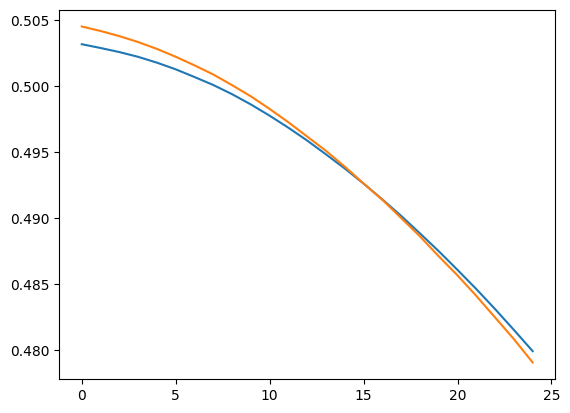

In [15]:
sns.lineplot(trainer.train_losses)
sns.lineplot(trainer.val_losses)